##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# On-Device Training in TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/on_device_training/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

**Note:** This API is new and only available via `pip install tf-nightly`. It will be available in TensorFlow version 2.7.

To use TensorFlow Lite, a developer needs to prepare a TensorFlow model, use the converter to convert it to TensorFlow Lite model format, and run the model using TensorFlow Lite on device. This is true for inference use cases, and a similar flow can be applied to training too.

The following code illustrates the high-level flow of preparing a TensorFlow training model, converting it to TensorFlow Lite model and running in TensorFlow Lite for a training use case.

The implementation is based on the [Keras classification example](https://www.tensorflow.org/tutorials/keras/classification) in the TensorFlow official guide page.

## Setup

In [ ]:
!pip uninstall -y tensorflow keras
!pip install tf-nightly

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Found existing installation: keras 2.6.0
Uninstalling keras-2.6.0:
  Successfully uninstalled keras-2.6.0
     |████████████████████████████████| 468.5 MB 199 bytes/s 
     |████████████████████████████████| 1.3 MB 31.2 MB/s 
     |████████████████████████████████| 12.8 MB 140 kB/s 
     |████████████████████████████████| 463 kB 66.9 MB/s 
     |████████████████████████████████| 2.3 MB 20.3 MB/s 
     |████████████████████████████████| 5.7 MB 18.7 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Classify images of clothing

This CoLab trains a neural network model to classify images of clothing, like sneakers and shirts.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the [Fashion MNIST data](https://keras.io/api/datasets/fashion_mnist/) directly from TensorFlow:

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

In [ ]:
train_images.shape

(60000, 28, 28)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Define a function `plot()` to print 25 images and their labels.

In [ ]:
def plot(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(class_names[labels[i]])
  plt.show()

Plot training images

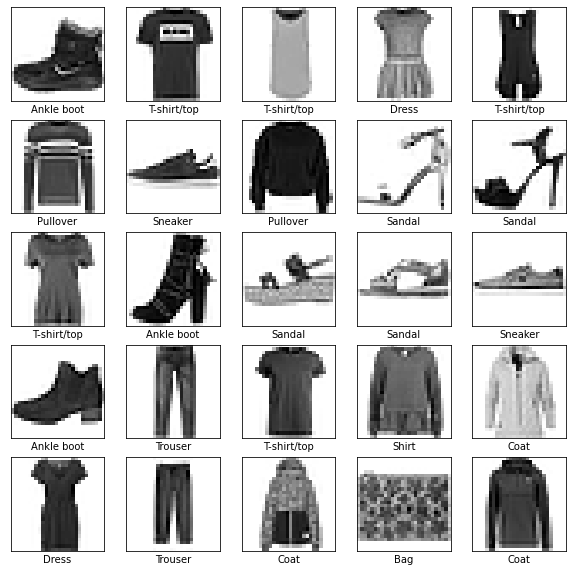

In [ ]:
plot(train_images, train_labels)

### TensorFlow Model for Training

Instead of converting a single TensorFlow model or tf.function to a TensorFlow Lite model with a single entry point, we can convert multiple tf.function(s) into a TensorFlow Lite model. To be able to do that, we're extending the TensorFlow Lite's converter & runtime to handle multiple signatures.

Preparing a TensorFlow Model. The code constructs a tf.module with 4 tf.functions:
*   train function trains the model with training data.
*   infer function invokes the inference.
*   save function saves the trainable weights into the file system.
*   restore function loads the trainable weights from the file system.

The weights will be serialized as a TensorFlow version one checkpoint file format.

In [ ]:
IMG_SIZE = 28


class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    self._LOSS_FN = tf.keras.losses.CategoricalCrossentropy()
    self._OPTIM = tf.optimizers.SGD()

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    # Gradient tape is used for recording operations for automatic
    # differentiation. You can refer to
    # https://www.tensorflow.org/api_docs/python/tf/GradientTape for more
    # details on how to use it.
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self._LOSS_FN(prediction, y)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self._OPTIM.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    for grad in gradients:
      result[grad.name] = grad
    return result

  @tf.function(input_signature=[tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32)])
  def predict(self, x):
    return {
        "output": self.model(x)
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

### Convert to TensorFlow Lite model

In [ ]:
# Export the TensorFlow model to the saved model
SAVED_MODEL_DIR = "saved_model"
m= Model()
tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.predict.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

### Train the TensorFlow Lite model


#### Preprocess the dataset

* Scale images from 0-255 to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255.
* Convert labels to categorical values, i.e, perform one-hot encoding.

It's important that the *training set* and the *testing set* be preprocessed in the same way.

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

#### Setup the TensorFlow Lite

TensorFlow Lite's converter and interpreter support multi-signature. Developers can choose to invoke restoring, training, saving and inferring signatures separately.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

train = interpreter.get_signature_runner("train")
infer = interpreter.get_signature_runner("infer")
save = interpreter.get_signature_runner("save")
restore = interpreter.get_signature_runner("restore")

On Android, TensorFlow Lite on-device training can be performed using either Java or C++ APIs. In this document, we describe how the above TensorFlow Lite model will work with Java API.

#### Train the model

Using the preprocessed dataset and the `train` signature method.

In [ ]:
# Run training for a few steps
NUM_EPOCHS = 100
for i in range(NUM_EPOCHS):
  result = train(
      x=tf.constant(train_images, shape=(len(train_images), IMG_SIZE, IMG_SIZE), dtype=tf.float32),
      y=tf.constant(train_labels, shape=(len(train_images), 10), dtype=tf.float32))
  if NUM_EPOCHS % 10 == 0:
    print("Current loss:", result['loss'])

Current loss: 14.396263
Current loss: 14.303606
Current loss: 14.217689
Current loss: 14.136439
Current loss: 14.057844
Current loss: 13.979243
Current loss: 13.897442
Current loss: 13.80926
Current loss: 13.711432
Current loss: 13.601482
Current loss: 13.477388
Current loss: 13.33926
Current loss: 13.188297
Current loss: 13.028339
Current loss: 12.86321
Current loss: 12.696561
Current loss: 12.532116
Current loss: 12.372246
Current loss: 12.218907
Current loss: 12.0738
Current loss: 11.936985
Current loss: 11.809245
Current loss: 11.690561
Current loss: 11.580731
Current loss: 11.479323
Current loss: 11.38568
Current loss: 11.299316
Current loss: 11.219543
Current loss: 11.145597
Current loss: 11.076766
Current loss: 11.012304
Current loss: 10.95145
Current loss: 10.893523
Current loss: 10.837595
Current loss: 10.782755
Current loss: 10.727857
Current loss: 10.671567
Current loss: 10.612212
Current loss: 10.547741
Current loss: 10.476793
Current loss: 10.399756
Current loss: 10.320941

In Java, you'll use the `Interpreter` class to load a model and drive model training tasks.
The following example shows how to run the training procedure by using the `runSignature` method:

```
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int NUM_TRAININGS = 60000;
    float[][][] trainImages = new float[NUM_TRAININGS][28][28];
    float[][] trainLabels = new float[NUM_TRAININGS][10];

    // Fill the data values.

    // Run training for a few steps.
    for (int i = 0; i < NUM_EPOCHS; ++i) {
        Map<String, Object> inputs = new HashMap<>();
        inputs.put("x", trainImages);
        inputs.put("y", trainLabels);
        Map<String, Object> outputs = new HashMap<>();
        FloatBuffer loss = FloatBuffer.allocate(1);
        outputs.put("loss", loss);
        interpreter.runSignature(inputs, outputs, "train");
    }

    // Do the other stuffs..
}
```

### Run inference on the trained TensorFlow Lite model
Now we have a trained TensorFlow Lite model, we can run inference on the test images using the signature runner API:

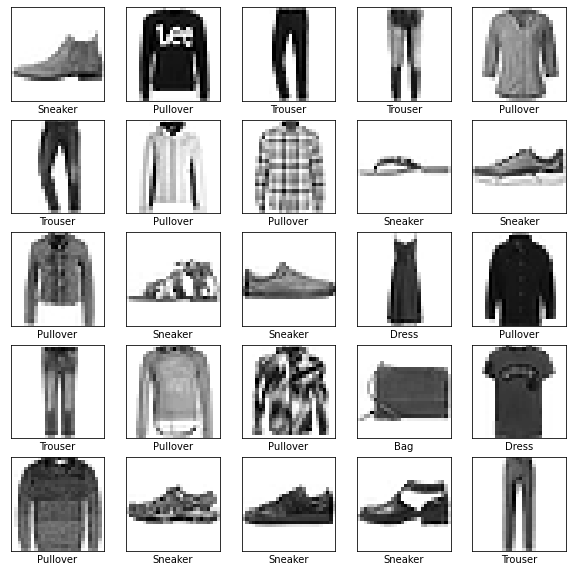

In [ ]:
infer = interpreter.get_signature_runner("infer")
result = infer(
    x=tf.constant(test_images, shape=(len(test_images), IMG_SIZE, IMG_SIZE), dtype=tf.float32))
result_labels = np.argmax(result["output"], axis=1)
plot(test_images, result_labels)

### Export the trained weights to the checkpoint file

The checkpoint file can be generated through the `save` signature method.

In [ ]:
save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'/tmp/model.ckpt', dtype=object)}

In Java, you can store the trained weight as a checkpoint format into the internal storage of the application. Training tasks usually perform at the idle time (e.g., at night time) in the background process occasionally.

```
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    interpreter.runSignature(inputs, outputs, "save");
}
```

### Restore the trained weights from the checkpoint file

The exported checkpoint file can be restored through the `restore` signature method.

In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)

train = another_interpreter.get_signature_runner("train")
infer = another_interpreter.get_signature_runner("infer")
save = another_interpreter.get_signature_runner("save")
restore = another_interpreter.get_signature_runner("restore")

# Restore the trained weights from /tmp/model.ckpt
# The time spent in weight restoration is proportionate to the checkpoint size
# and the number of variables in the model.
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'dense_2/bias:0': array([ 5.50814066e-03,  1.63249875e-04, -2.55855732e-03,  8.71338043e-03,
         2.66851392e-03, -3.30125843e-03, -4.12533386e-03, -1.44013751e-03,
         2.71035433e-02,  6.02910109e-03,  1.14851762e-02,  1.27093988e-02,
        -5.43930288e-03,  4.78171138e-03,  2.36648461e-03,  4.66894358e-03,
        -2.91200704e-03,  9.43728723e-03,  1.14521412e-02,  3.59242922e-03,
         3.82418570e-04,  8.97759292e-03, -4.25201748e-03, -6.41951663e-03,
         1.63362026e-02, -3.51130799e-03, -1.25751842e-03,  3.87191284e-03,
         5.15990192e-04,  5.73161431e-03,  9.90258064e-04,  1.48530537e-02,
        -5.18084643e-03,  1.23257069e-02,  3.77742108e-03,  2.69266893e-03,
        -1.81903306e-03,  5.38993347e-03,  1.79503821e-02,  8.09132867e-03,
         4.27707145e-03, -6.18034974e-04,  6.64335536e-03,  2.47712247e-03,
         6.56080898e-03, -2.00155634e-03,  9.76888649e-03, -7.13824120e-04,
         2.58168159e-03, -1.01994065e-05, -7.36352522e-04,  4.00819443

In Java, you can restore the serialized trained weights from the file, stored at the internal storage. When the application restarts, the trained weights
usually need to be restored prior to the inferences.

```
try (Interpreter another_interpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    another_interpreter.runSignature(inputs, outputs, "restore");
}
```

### Run Inference using the trained weights

Developers can use the trained model to run inference through the `infer` signature method.

In [ ]:
result = infer(
    x=tf.constant(test_images, shape=(len(test_images), IMG_SIZE, IMG_SIZE), dtype=tf.float32))
result_labels = np.argmax(result["output"], axis=1)

Plot the predicted labels

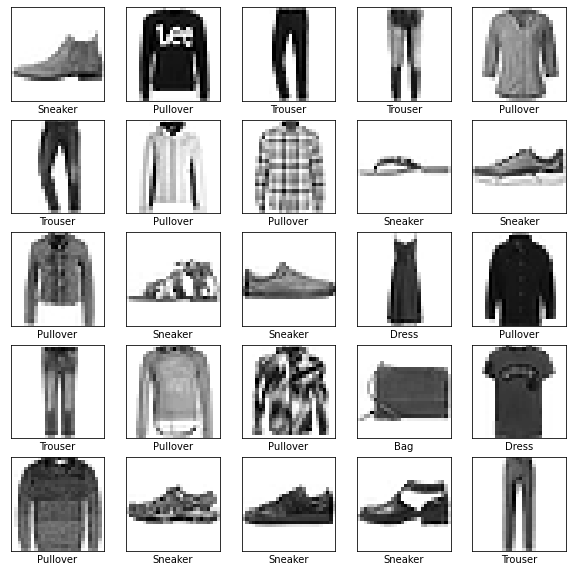

In [ ]:
plot(test_images, result_labels)

In Java, after restoring the trained weights, developers can run the inferences based on the loaded data.

```
try (Interpreter another_interpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    float[][][] testImages = new float[NUM_TESTS][28][28];
    float[][] output = new float[NUM_TESTS][10];

    // Fill the test data.

    // Run the inference.
    inputs = new HashMap<>();
    inputs.put("x", testImages);
    outputs = new HashMap<>();
    outputs.put("output", output);
    another_interpreter.runSignature(inputs, outputs, "infer");

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output[i][index] < output[i][j]) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```